# RSNA 2024 Lumbar Spine Degenerative Classification

In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
# read data
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [3]:
test_desc.head(5)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [4]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [5]:
train_desc.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [6]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, f'{train_path}/train_images')
test_image_paths = generate_image_paths(test_desc, f'{train_path}/test_images')

In [7]:
len(train_desc)

6294

In [8]:
len(train_image_paths)

147218

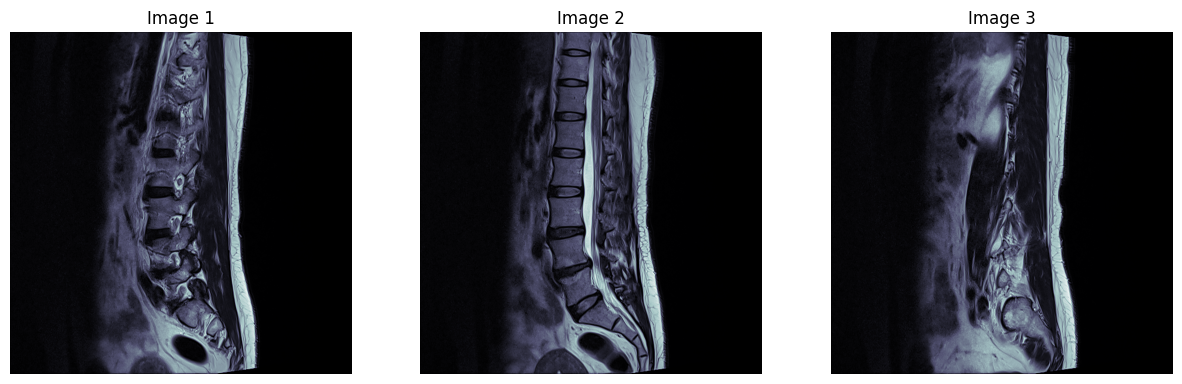

In [9]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

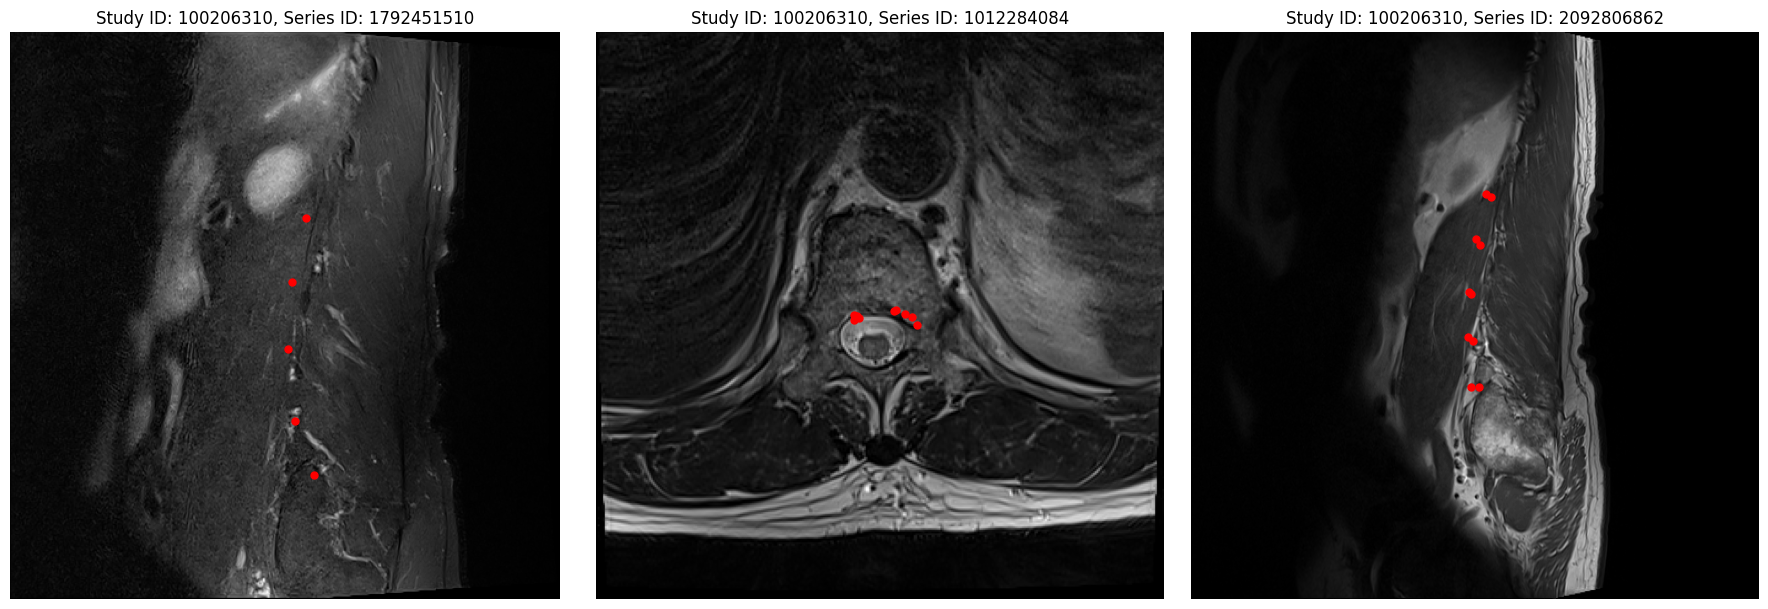

In [10]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):  # Display images
        study_id = int(path.split('/')[-3])
        series_id = int(path.split('/')[-2])
        
        # Filter label coordinates for the current study and series
        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        
        # Read DICOM image
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
        
    plt.tight_layout()
    plt.show()

# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
study_folder = f'{train_path}/train_images/{study_id}'

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series


display_dicom_with_coordinates(image_paths, label)

## Data Preprocessing

In [11]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [12]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [14]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [15]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [16]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x','y'],ascending = True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2


In [17]:
final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


Now, we can see what the data represents

Series ID 1012284084 contains 60 images, and how each image maps to each level and condition

In [18]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("instance_number")

# Display the resulting dataframe
filtered_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR


In [19]:
# Sort final_merged_df by study_id, series_id, and series_description
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2/STIR
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2/STIR
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2/STIR
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2/STIR
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2/STIR
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


We see that, <br>
Saggital T1 images map to Neural Foraminal Narrowing <br>
Axial T2 images map to Subarticular Stenosis <br>
Saggital T2/STIR map to Canal Stenosis <br>

In [20]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}/train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [21]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()

37626

In [22]:
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7950

In [23]:
# Define the base path for test images
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [24]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [25]:
test_data = expanded_test_desc
train_data = final_merged_df

In [26]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [27]:
train_data.head(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [28]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

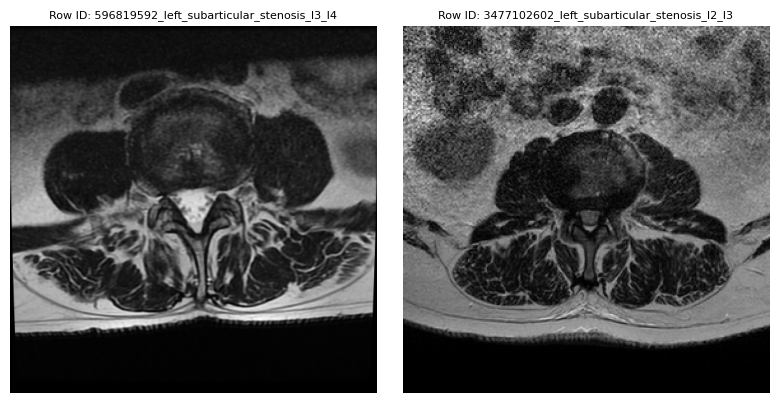

In [29]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Loading data

In [30]:
#for one hot encoding
#train_data[['normal_mild', 'severe', 'moderate']] = train_data[['normal_mild', 'severe', 'moderate']].astype(int)  

In [31]:
train_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,True,True,True


In [32]:
train_data = train_data.dropna()

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        label = self.dataframe['severity'][index]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

# Dictionary mapping labels to indices
label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}

Visualizing Sagittal T1 samples


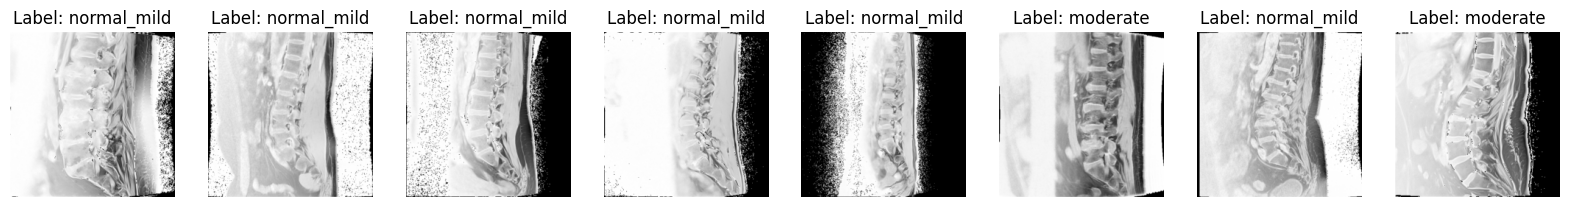

Visualizing Axial T2 samples


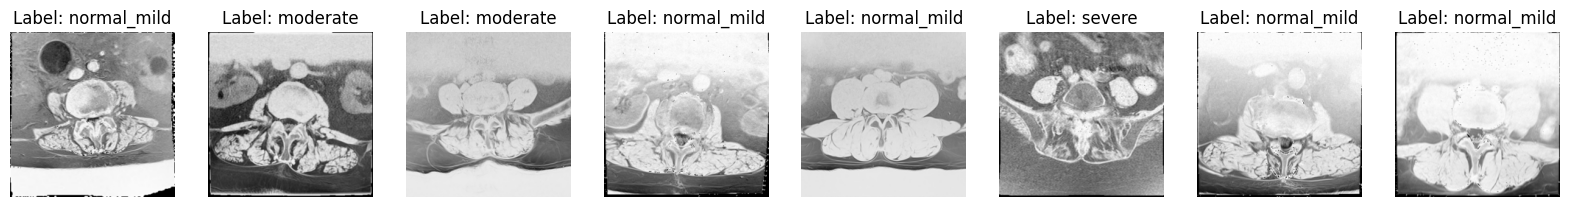

Visualizing Sagittal T2/STIR samples


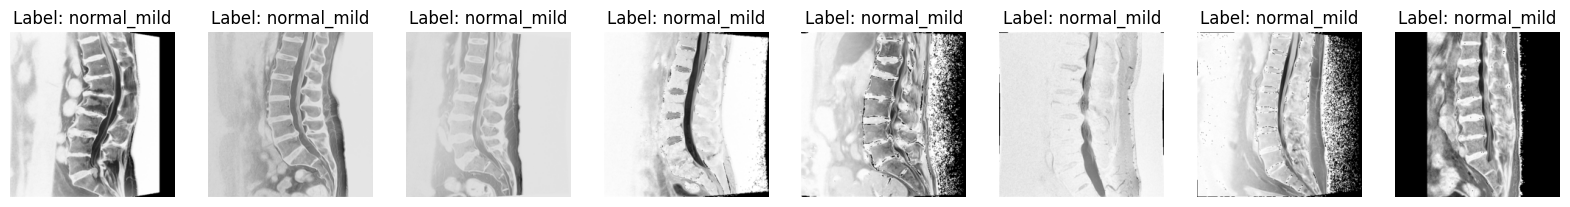

In [33]:
import matplotlib.pyplot as plt

# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0)  # Convert to HWC for visualization
        ax.imshow(img)
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    plt.show()

# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples")
visualize_batch(trainloader_t2stir)

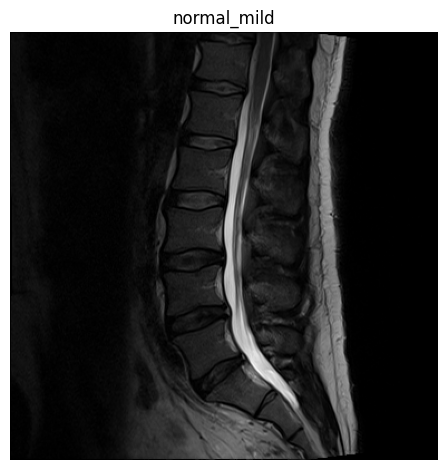

In [34]:
import matplotlib.pyplot as plt

image, label = next(iter(trainloader_t2))
sample = image[1].permute(1, 2, 0)  #sample

# Plot images
plt.figsize=(8, 4)
plt.imshow(images[0], cmap='gray')
plt.title(label[0])
plt.axis('off')
plt.tight_layout()
plt.show()

## Model

ConvNext

In [35]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze the last 20 layers, keeping BatchNorm layers frozen
        for layer in list(self.model.features.children())[-20:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
        
        # Unfreeze the classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Path to the locally uploaded weights file
weights_path = '/kaggle/input/efficientnetv2/pytorch/efficientnetv2s/1/efficientnet_v2_s-dd5fe13b.pth'

# Initialize models
sagittal_t1_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
axial_t2_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)
sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

# Optionally freeze initial layers
for param in sagittal_t1_model.model.features.parameters():
    param.requires_grad = False
for param in axial_t2_model.model.features.parameters():
    param.requires_grad = False
for param in sagittal_t2stir_model.model.features.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in sagittal_t1_model.model.classifier.parameters():
    param.requires_grad = True
for param in axial_t2_model.model.classifier.parameters():
    param.requires_grad = True
for param in sagittal_t2stir_model.model.classifier.parameters():
    param.requires_grad = True

# Training parameters
criterion = nn.CrossEntropyLoss()

# Initialize separate optimizers for each model
optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.model.classifier.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.model.classifier.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.model.classifier.parameters(), lr=0.001)

# Store the models and optimizers in dictionaries for easy access
models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

In [37]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 3843


## Training

In [38]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

In [39]:
for images, labels in trainloader_t2:
    labels = torch.tensor([label_map[label] for label in labels])
    labels = labels.to(device)
    print(labels)
    break

tensor([0, 0, 0, 2, 0, 0, 0, 0], device='cuda:0')


In [40]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1).squeeze(0)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [ ]:
# Training all models
for desc, model in models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
    
    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

Training model for Sagittal T1


100%|██████████| 493/493 [01:35<00:00,  5.16batch/s, epoch=1]


Epoch 1, Train Loss: 0.6614, Train Acc: 77.00%, Val Loss: 0.6467, Val Acc: 76.54%


100%|██████████| 493/493 [01:35<00:00,  5.16batch/s, epoch=2]


Epoch 2, Train Loss: 0.6525, Train Acc: 76.88%, Val Loss: 0.6418, Val Acc: 77.25%


100%|██████████| 493/493 [01:35<00:00,  5.18batch/s, epoch=3]


Epoch 3, Train Loss: 0.6282, Train Acc: 77.37%, Val Loss: 0.6312, Val Acc: 77.71%


100%|██████████| 493/493 [01:34<00:00,  5.22batch/s, epoch=4]


Epoch 4, Train Loss: 0.6261, Train Acc: 77.49%, Val Loss: 0.6242, Val Acc: 77.99%


100%|██████████| 493/493 [01:34<00:00,  5.24batch/s, epoch=5]


Epoch 5, Train Loss: 0.6174, Train Acc: 77.63%, Val Loss: 0.6258, Val Acc: 77.74%


100%|██████████| 493/493 [01:33<00:00,  5.25batch/s, epoch=6]


Epoch 6, Train Loss: 0.6176, Train Acc: 77.69%, Val Loss: 0.6302, Val Acc: 77.56%


100%|██████████| 493/493 [01:34<00:00,  5.20batch/s, epoch=7]


Epoch 7, Train Loss: 0.6210, Train Acc: 77.73%, Val Loss: 0.6233, Val Acc: 77.84%
Early stopping triggered after 7 epochs
Training model for Axial T2


100%|██████████| 481/481 [01:25<00:00,  5.66batch/s, epoch=1]


Epoch 1, Train Loss: 0.7433, Train Acc: 70.49%, Val Loss: 0.7082, Val Acc: 70.31%


100%|██████████| 481/481 [01:10<00:00,  6.86batch/s, epoch=2]


Epoch 2, Train Loss: 0.7281, Train Acc: 70.48%, Val Loss: 0.6870, Val Acc: 71.30%


100%|██████████| 481/481 [01:07<00:00,  7.08batch/s, epoch=3]


Epoch 3, Train Loss: 0.6950, Train Acc: 71.49%, Val Loss: 0.6785, Val Acc: 71.64%


 36%|███▋      | 697/1922 [01:40<03:23,  6.03batch/s, epoch=4]

## Inference

In [ ]:
train_data['level'].unique()

In [ ]:
expanded_test_desc.head(5)

In [ ]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

# Function to update row_id with levels
def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f"{row['study_id']}_{row['condition']}_{level}"

# Update row_id in expanded_test_desc to include levels
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

In [ ]:
expanded_test_desc.head(2)

In [ ]:
# Define a custom test dataset class
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        if self.transform:
            image = self.transform(image)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(expanded_test_desc, transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
for image in testloader:
    print(image.shape)
    break

In [ ]:
# Function to get the model based on series_description
def get_model(series_description):
    return models.get(series_description, None)

# Function to make predictions on the test data
def predict_test_data(testloader, expanded_test_desc):
    predictions = []
    normal_mild_probs = []
    moderate_probs = []
    severe_probs = []
    
    for model in models.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            images = images.to(device)
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            if model:
                model.eval()  # Set the model to eval mode
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1).squeeze(0)
                normal_mild_probs.append(probs[0].item())
                moderate_probs.append(probs[1].item())
                severe_probs.append(probs[2].item())
                predictions.append(probs)
            else:
                normal_mild_probs.append(None)
                moderate_probs.append(None)
                severe_probs.append(None)
                predictions.append(None)
    return normal_mild_probs, moderate_probs, severe_probs, predictions

In [ ]:
# Make predictions on the test data
normal_mild_probs, moderate_probs, severe_probs, test_predictions = predict_test_data(testloader, expanded_test_desc)

In [ ]:
test_predictions[0]

In [ ]:
# Add predictions and probabilities to the test DataFrame
expanded_test_desc['normal_mild'] = normal_mild_probs
expanded_test_desc['moderate'] = moderate_probs
expanded_test_desc['severe'] = severe_probs

In [ ]:
submission = expanded_test_desc[["row_id","normal_mild","moderate","severe"]]

In [ ]:
submission.head(10)

In [ ]:
# Group by 'row_id' and sum the values
grouped_submission = submission.groupby('row_id').max().reset_index()

# Normalize the columns
#grouped_submission[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']].div(grouped_submission[['normal_mild', 'moderate', 'severe']].sum(axis=1), axis=0)

# Check the first 3 rows
grouped_submission

In [ ]:
len(grouped_submission)

In [ ]:
sub[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']]

In [ ]:
import os

# Save the DataFrame to "submission.csv" in the desired directory
sub.to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
sub.head(5)

In [42]:
from tqdm import tqdm
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train_severity = 0
        correct_train_condition = 0
        correct_train_level = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, severity_labels, condition_labels, level_labels in tepoch:
                images = images.to(device)
                severity_labels = severity_labels.to(device)
                condition_labels = condition_labels.to(device)
                level_labels = level_labels.to(device)
                
                optimizer.zero_grad()
                
                severity_out, condition_out, level_out = model(images)
                
                # Calculate loss for each task
                loss_severity = criterion(severity_out, severity_labels)
                loss_condition = criterion(condition_out, condition_labels)
                loss_level = criterion(level_out, level_labels)
                
                # Combined loss
                loss = loss_severity + loss_condition + loss_level
                
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                # Calculate accuracy for each task
                _, predicted_severity = torch.max(severity_out, 1)
                _, predicted_condition = torch.max(condition_out, 1)
                _, predicted_level = torch.max(level_out, 1)
                
                correct_train_severity += (predicted_severity == severity_labels).sum().item()
                correct_train_condition += (predicted_condition == condition_labels).sum().item()
                correct_train_level += (predicted_level == level_labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc_severity = 100 * correct_train_severity / len_train
        train_acc_condition = 100 * correct_train_condition / len_train
        train_acc_level = 100 * correct_train_level / len_train
        
        model.eval()
        val_loss = 0
        correct_val_severity = 0
        correct_val_condition = 0
        correct_val_level = 0
        
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, severity_labels, condition_labels, level_labels in vepoch:
                    images = images.to(device)
                    severity_labels = severity_labels.to(device)
                    condition_labels = condition_labels.to(device)
                    level_labels = level_labels.to(device)
                    
                    severity_out, condition_out, level_out = model(images)
                    
                    loss_severity = criterion(severity_out, severity_labels)
                    loss_condition = criterion(condition_out, condition_labels)
                    loss_level = criterion(level_out, level_labels)
                    
                    loss = loss_severity + loss_condition + loss_level
                    val_loss += loss.item()
                    
                    _, predicted_severity = torch.max(severity_out, 1)
                    _, predicted_condition = torch.max(condition_out, 1)
                    _, predicted_level = torch.max(level_out, 1)
                    
                    correct_val_severity += (predicted_severity == severity_labels).sum().item()
                    correct_val_condition += (predicted_condition == condition_labels).sum().item()
                    correct_val_level += (predicted_level == level_labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc_severity = 100 * correct_val_severity / len_val
        val_acc_condition = 100 * correct_val_condition / len_val
        val_acc_level = 100 * correct_val_level / len_val
        
        avg_val_acc = (val_acc_severity + val_acc_condition + val_acc_level) / 3
        
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Accuracy - Severity: {train_acc_severity:.2f}%, Condition: {train_acc_condition:.2f}%, Level: {train_acc_level:.2f}%")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy - Severity: {val_acc_severity:.2f}%, Condition: {val_acc_condition:.2f}%, Level: {val_acc_level:.2f}%")
        
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(best_model_wts)
    return model, best_val_acc


In [ ]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = '/kaggle/input/efficientnetv2/pytorch/efficientnetv2s/1/efficientnet_v2_s-dd5fe13b.pth'

sagittal_t1_model = CustomEfficientNetV2(
    num_severity_classes=3,
    num_condition_classes=5,
    num_level_classes=5,
    pretrained_weights=weights_path
).to(device)

axial_t2_model = CustomEfficientNetV2(
    num_severity_classes=3,
    num_condition_classes=5,
    num_level_classes=5,
    pretrained_weights=weights_path
).to(device)

sagittal_t2stir_model = CustomEfficientNetV2(
    num_severity_classes=3,
    num_condition_classes=5,
    num_level_classes=5,
    pretrained_weights=weights_path
).to(device)

# Initialize optimizers
optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.parameters(), lr=0.001)

# Store models and optimizers in dictionaries
models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}

optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

def predict_test_data(testloader, expanded_test_desc):
    predictions_severity = []
    predictions_condition = []
    predictions_level = []
    
    for model in models.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            images = images.to(device)
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            
            if model:
                model.eval()
                severity_out, condition_out, level_out = model(images)
                
                # Get probabilities for each task
                severity_probs = torch.softmax(severity_out, dim=1).squeeze(0)
                condition_probs = torch.softmax(condition_out, dim=1).squeeze(0)
                level_probs = torch.softmax(level_out, dim=1).squeeze(0)
                
                predictions_severity.append(severity_probs)
                predictions_condition.append(condition_probs)
                predictions_level.append(level_probs)
            else:
                predictions_severity.append(None)
                predictions_condition.append(None)
                predictions_level.append(None)
                
    return predictions_severity, predictions_condition, predictions_level

def prepare_submission(predictions_severity, predictions_condition, predictions_level, expanded_test_desc):
    # Create reversed mappings
    rev_severity_map = {v: k for k, v in severity_map.items()}
    rev_condition_map = {v: k for k, v in condition_map.items()}
    rev_level_map = {v: k for k, v in level_map.items()}
    
    # Create submission DataFrame
    submission = pd.DataFrame()
    submission['row_id'] = expanded_test_desc['row_id']
    
    # Add predictions for all tasks
    for i in range(len(predictions_severity)):
        if predictions_severity[i] is not None:
            severity_probs = predictions_severity[i].cpu().numpy()
            condition_probs = predictions_condition[i].cpu().numpy()
            level_probs = predictions_level[i].cpu().numpy()
            
            for j, sev in enumerate(['normal_mild', 'moderate', 'severe']):
                submission.loc[i, sev] = severity_probs[j]
            
            # Add condition and level predictions
            predicted_condition = rev_condition_map[np.argmax(condition_probs)]
            predicted_level = rev_level_map[np.argmax(level_probs)]
            
            # Add probabilities for each condition
            for j, cond in enumerate(condition_map.keys()):
                submission.loc[i, f'condition_{cond}'] = condition_probs[j]
            
            # Add probabilities for each level
            for j, lvl in enumerate(level_map.keys()):
                submission.loc[i, f'level_{lvl}'] = level_probs[j]
    
    return submission

# Create test dataset class
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['image_path'].iloc[idx]
        image = load_dicom(image_path)
        
        if self.transform:
            image = self.transform(image)
        return image

# Training loop for all models
def train_all_models():
    results = {}
    
    for desc, model in models.items():
        print(f"\nTraining model for {desc}")
        
        if desc == 'Sagittal T1':
            trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
        elif desc == 'Axial T2':
            trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
        elif desc == 'Sagittal T2/STIR':
            trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
        
        trained_model, best_val_acc = train_model(
            model, 
            trainloader, 
            valloader, 
            len_train, 
            len_val, 
            optimizers[desc],
            num_epochs=10,
            patience=3
        )
        
        results[desc] = {
            'model': trained_model,
            'best_val_acc': best_val_acc
        }
        
        # Save the model
        torch.save(trained_model.state_dict(), f'best_model_{desc.lower().replace("/", "_")}.pth')
    
    return results

# Main execution
if __name__ == "__main__":
    # Create dataloaders
    trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(
        train_data, 'Sagittal T1', transform)
    trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(
        train_data, 'Axial T2', transform)
    trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(
        train_data, 'Sagittal T2/STIR', transform)

    # Train all models
    results = train_all_models()

    # Create test dataset and dataloader
    test_dataset = TestDataset(expanded_test_desc, transform)
    testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Make predictions
    predictions_severity, predictions_condition, predictions_level = predict_test_data(
        testloader, expanded_test_desc)

    # Prepare submission
    submission_df = prepare_submission(
        predictions_severity, 
        predictions_condition, 
        predictions_level, 
        expanded_test_desc
    )

    # Group by row_id and aggregate
    final_submission = submission_df.groupby('row_id').agg({
        'normal_mild': 'max',
        'moderate': 'max',
        'severe': 'max'
    }).reset_index()

    # Save submission
    final_submission.to_csv('submission.csv', index=False)

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from copy import deepcopy
import os
import pydicom
import matplotlib.pyplot as plt

In [3]:
# Load CSV files for train and test data
train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
train_data = pd.read_csv(train_path + 'train.csv')
label_data = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc = pd.read_csv(train_path + 'test_series_descriptions.csv')

# Display the first few rows of the train data
train_data.head()


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [10]:
# Function to reshape the train_data DataFrame
def reshape_train_data(df):
    reshaped_data = []
    for index, row in df.iterrows():
        for col in df.columns:
            if col != 'study_id':
                condition, level = col.rsplit('_', 2)[0], '_'.join(col.rsplit('_', 2)[1:])
                reshaped_data.append({
                    'study_id': row['study_id'],
                    'condition': condition.replace('_', ' ').title(),
                    'level': level.replace('_', '/').upper(),
                    'severity': row[col]  # Assumes severity is stored in the value (e.g., normal_mild, moderate, severe)
                })
    reshaped_df = pd.DataFrame(reshaped_data)
    return reshaped_df

# Reshape the train_data DataFrame
train_data_reshaped = reshape_train_data(train_data)

# Display the reshaped DataFrame
train_data_reshaped.head()


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [ ]:
df=train_data_reshaped

In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import os
import pydicom
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_v2_s
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 2: Set Device and Random Seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

Using device: cuda


In [3]:
# Step 3: Define Constants
TRAIN_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

CONDITION_MAP = {
    'Left Neural Foraminal Narrowing': 0,
    'Right Neural Foraminal Narrowing': 1,
    'Left Subarticular Stenosis': 2,
    'Right Subarticular Stenosis': 3,
    'Canal Stenosis': 4
}

LEVEL_MAP = {
    'L1/L2': 0,
    'L2/L3': 1,
    'L3/L4': 2,
    'L4/L5': 3,
    'L5/S1': 4
}

SEVERITY_MAP = {
    'normal_mild': 0,
    'moderate': 1,
    'severe': 2
}

In [ ]:
# Step 4: Define Helper Functions
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [12]:
# Step 5: Load Raw Data
def load_raw_data():
    print("Loading raw data files...")
    train = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
    label = pd.read_csv(os.path.join(TRAIN_PATH, 'train_label_coordinates.csv'))
    train_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'train_series_descriptions.csv'))
    
    print(f"Train shape: {train.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Train descriptions shape: {train_desc.shape}")
    
    return train, label, train_desc

In [13]:
# Step 6: Data Preprocessing
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id']:
            if pd.notnull(value) and value in ['Normal/Mild', 'Moderate', 'Severe']:
                parts = column.split('_')
                level_parts = parts[-2:]
                condition_parts = parts[:-2]
                
                level = '/'.join(part.upper() for part in level_parts)
                condition = ' '.join(part.capitalize() for part in condition_parts)
                
                if condition == 'Spinal Canal Stenosis':
                    condition = 'Canal Stenosis'
                
                data['study_id'].append(row['study_id'])
                data['condition'].append(condition)
                data['level'].append(level)
                data['severity'].append(value)
    
    return pd.DataFrame(data)

def preprocess_data():
    # Load raw data
    train, label, train_desc = load_raw_data()
    
    # Reshape training data
    print("Reshaping training data...")
    reshaped_dfs = []
    for _, row in tqdm(train.iterrows(), total=len(train)):
        reshaped_df = reshape_row(row)
        if len(reshaped_df) > 0:
            reshaped_dfs.append(reshaped_df)
    
    new_train_df = pd.concat(reshaped_dfs, ignore_index=True)
    
    # Standardize severity values
    new_train_df['severity'] = new_train_df['severity'].replace({
        'Normal/Mild': 'normal_mild',
        'Moderate': 'moderate',
        'Severe': 'severe'
    })
    
    # Merge dataframes
    print("Merging dataframes...")
    merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
    final_merged_df = pd.merge(merged_df, train_desc, on=['series_id', 'study_id'], how='inner')
    
    # Create image paths
    print("Creating image paths...")
    final_merged_df['image_path'] = (
        f'{TRAIN_PATH}/train_images/' + 
        final_merged_df['study_id'].astype(str) + '/' +
        final_merged_df['series_id'].astype(str) + '/' +
        final_merged_df['instance_number'].astype(str) + '.dcm'
    )
    
    # Filter existing images
    final_merged_df = final_merged_df[final_merged_df['image_path'].apply(os.path.exists)]
    
    print("\nFinal dataset statistics:")
    print(f"Total samples: {len(final_merged_df)}")
    print("\nCondition distribution:")
    print(final_merged_df['condition'].value_counts())
    print("\nLevel distribution:")
    print(final_merged_df['level'].value_counts())
    print("\nSeverity distribution:")
    print(final_merged_df['severity'].value_counts())
    
    return final_merged_df

In [14]:
# Step 7: Define Dataset Class
class SpineDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            image = load_dicom(row['image_path'])
            
            if self.transform:
                image = self.transform(image)
            
            severity = torch.tensor(SEVERITY_MAP[row['severity']])
            condition = torch.tensor(CONDITION_MAP[row['condition']])
            level = torch.tensor(LEVEL_MAP[row['level']])
            
            return image, severity, condition, level
        except Exception as e:
            print(f"Error at index {idx}:")
            print(f"Row data: {row}")
            raise e

In [15]:
# Step 8: Model Definition
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_severity_classes=3, num_condition_classes=5, num_level_classes=5):
        super(CustomEfficientNetV2, self).__init__()
        
        self.model = efficientnet_v2_s(weights='DEFAULT')
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier = nn.Identity()
        
        self.shared_features = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.severity_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_severity_classes)
        )
        
        self.condition_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_condition_classes)
        )
        
        self.level_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_level_classes)
        )

    def forward(self, x):
        features = self.model(x)
        shared_features = self.shared_features(features)
        
        severity_out = self.severity_classifier(shared_features)
        condition_out = self.condition_classifier(shared_features)
        level_out = self.level_classifier(shared_features)
        
        return severity_out, condition_out, level_out

In [16]:
# Step 9: Create Data Loaders
def create_data_loaders(df, batch_size=32):
    # Create train/val split
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df[['condition', 'level', 'severity']]
    )
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = SpineDataset(train_df, transform=transform)
    val_dataset = SpineDataset(val_df, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [17]:
# Step 10: Training Functions
def train_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct_severity = 0
    correct_condition = 0
    correct_level = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (images, severity_labels, condition_labels, level_labels) in enumerate(progress_bar):
        # Move to device
        images = images.to(DEVICE)
        severity_labels = severity_labels.to(DEVICE)
        condition_labels = condition_labels.to(DEVICE)
        level_labels = level_labels.to(DEVICE)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        severity_out, condition_out, level_out = model(images)
        
        # Calculate loss
        loss_severity = criterion(severity_out, severity_labels)
        loss_condition = criterion(condition_out, condition_labels)
        loss_level = criterion(level_out, level_labels)
        loss = loss_severity + loss_condition + loss_level
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted_severity = torch.max(severity_out, 1)
        _, predicted_condition = torch.max(condition_out, 1)
        _, predicted_level = torch.max(level_out, 1)
        
        total += severity_labels.size(0)
        correct_severity += (predicted_severity == severity_labels).sum().item()
        correct_condition += (predicted_condition == condition_labels).sum().item()
        correct_level += (predicted_level == level_labels).sum().item()
        
        # Update total loss
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'sev_acc': f'{100.*correct_severity/total:.2f}%',
            'cond_acc': f'{100.*correct_condition/total:.2f}%',
            'level_acc': f'{100.*correct_level/total:.2f}%'
        })
    
    return total_loss / len(train_loader), {
        'severity': 100. * correct_severity / total,
        'condition': 100. * correct_condition / total,
        'level': 100. * correct_level / total
    }

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct_severity = 0
    correct_condition = 0
    correct_level = 0
    total = 0
    
    with torch.no_grad():
        for images, severity_labels, condition_labels, level_labels in tqdm(val_loader, desc='Validation'):
            images = images.to(DEVICE)
            severity_labels = severity_labels.to(DEVICE)
            condition_labels = condition_labels.to(DEVICE)
            level_labels = level_labels.to(DEVICE)
            
            severity_out, condition_out, level_out = model(images)
            
            loss_severity = criterion(severity_out, severity_labels)
            loss_condition = criterion(condition_out, condition_labels)
            loss_level = criterion(level_out, level_labels)
            loss = loss_severity + loss_condition + loss_level
            
            total_loss += loss.item()
            
            _, predicted_severity = torch.max(severity_out, 1)
            _, predicted_condition = torch.max(condition_out, 1)
            _, predicted_level = torch.max(level_out, 1)
            
            total += severity_labels.size(0)
            correct_severity += (predicted_severity == severity_labels).sum().item()
            correct_condition += (predicted_condition == condition_labels).sum().item()
            correct_level += (predicted_level == level_labels).sum().item()
    
    return total_loss / len(val_loader), {
        'severity': 100. * correct_severity / total,
        'condition': 100. * correct_condition / total,
        'level': 100. * correct_level / total
    }

In [18]:
# Step 11: Main Training Loop
def train_model(model, train_loader, val_loader, num_epochs=25, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    
    best_val_loss = float('inf')
    best_model = None
    history = []
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, epoch+1)
        
        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}')
            best_val_loss = val_loss
            best_model = deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'best_val_loss': best_val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc
            }, f'best_model_epoch_{epoch+1}.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            print(f'Validation loss did not improve from {best_val_loss:.4f}')
            if early_stopping_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        
        # Store metrics
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Print detailed metrics
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Training Accuracy - Severity: {train_acc["severity"]:.2f}%, '
              f'Condition: {train_acc["condition"]:.2f}%, Level: {train_acc["level"]:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy - Severity: {val_acc["severity"]:.2f}%, '
              f'Condition: {val_acc["condition"]:.2f}%, Level: {val_acc["level"]:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Save final training history
    history_df = pd.DataFrame(history)
    history_df.to_csv('training_history.csv', index=False)
    
    return model, history

In [19]:
# Step 12: Run Training
if __name__ == "__main__":
    print("Starting complete pipeline...")
    
    # Preprocess data
    print("\nPreprocessing data...")
    df = preprocess_data()
    
    # Create data loaders
    print("\nCreating data loaders...")
    train_loader, val_loader = create_data_loaders(df)
    
    # Initialize model
    print("\nInitializing model...")
    model = CustomEfficientNetV2().to(DEVICE)
    
    # Train model
    print("\nStarting training...")
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=25,  # Set to 25 epochs
        patience=5      # Early stopping patience
    )
    
    # Save final model
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'history': history,
    }, 'final_model.pth')
    
    print("\nTraining completed successfully!")

Starting complete pipeline...

Preprocessing data...
Loading raw data files...
Train shape: (1975, 26)
Label shape: (48692, 7)
Train descriptions shape: (6294, 3)
Reshaping training data...


100%|██████████| 1975/1975 [00:01<00:00, 1390.54it/s]


Merging dataframes...
Creating image paths...

Final dataset statistics:
Total samples: 38904

Condition distribution:
condition
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9829
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9603
Name: count, dtype: int64

Level distribution:
level
L4/L5    7879
L3/L4    7878
L5/S1    7868
L2/L3    7720
L1/L2    7559
Name: count, dtype: int64

Severity distribution:
severity
normal_mild    29074
moderate        7218
severe          2612
Name: count, dtype: int64

Creating data loaders...
Training samples: 31123
Validation samples: 7781

Initializing model...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 135MB/s] 



Starting training...

Epoch 1/25


Validation: 100%|██████████| 244/244 [01:00<00:00,  4.05it/s]


Validation loss improved from inf to 1.8322
Training Loss: 2.1047
Training Accuracy - Severity: 75.95%, Condition: 71.92%, Level: 53.43%
Validation Loss: 1.8322
Validation Accuracy - Severity: 77.61%, Condition: 73.69%, Level: 59.63%
Learning Rate: 0.001

Epoch 2/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.26it/s]


Validation loss improved from 1.8322 to 1.7701
Training Loss: 1.8008
Training Accuracy - Severity: 77.48%, Condition: 73.39%, Level: 60.81%
Validation Loss: 1.7701
Validation Accuracy - Severity: 78.68%, Condition: 73.05%, Level: 61.29%
Learning Rate: 0.001

Epoch 3/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.25it/s]


Validation loss improved from 1.7701 to 1.7176
Training Loss: 1.7259
Training Accuracy - Severity: 77.87%, Condition: 73.92%, Level: 61.93%
Validation Loss: 1.7176
Validation Accuracy - Severity: 78.70%, Condition: 74.64%, Level: 62.34%
Learning Rate: 0.001

Epoch 4/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.26it/s]


Validation loss improved from 1.7176 to 1.6455
Training Loss: 1.6831
Training Accuracy - Severity: 78.65%, Condition: 74.60%, Level: 63.13%
Validation Loss: 1.6455
Validation Accuracy - Severity: 79.06%, Condition: 74.91%, Level: 63.67%
Learning Rate: 0.001

Epoch 5/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.27it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.6362
Training Accuracy - Severity: 79.38%, Condition: 74.48%, Level: 63.54%
Validation Loss: 1.6801
Validation Accuracy - Severity: 78.50%, Condition: 73.87%, Level: 63.77%
Learning Rate: 0.001

Epoch 6/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.28it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5897
Training Accuracy - Severity: 80.02%, Condition: 74.66%, Level: 64.41%
Validation Loss: 1.6580
Validation Accuracy - Severity: 79.10%, Condition: 74.72%, Level: 63.80%
Learning Rate: 0.001

Epoch 7/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.28it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5670
Training Accuracy - Severity: 80.09%, Condition: 74.66%, Level: 64.87%
Validation Loss: 1.6794
Validation Accuracy - Severity: 79.45%, Condition: 74.68%, Level: 64.13%
Learning Rate: 0.001

Epoch 8/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.29it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5354
Training Accuracy - Severity: 81.06%, Condition: 74.88%, Level: 65.06%
Validation Loss: 1.7251
Validation Accuracy - Severity: 78.41%, Condition: 74.78%, Level: 63.77%
Learning Rate: 0.0001

Epoch 9/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.27it/s]


Validation loss did not improve from 1.6455
Early stopping triggered after 9 epochs

Training completed successfully!


In [ ]:
# Let's test each step
if __name__ == "__main__":
    print("Starting pipeline test...")
    
    # Test data preprocessing
    print("\nTesting data preprocessing...")
    df = preprocess_data()
    
    # Test data loaders
    print("\nTesting data loaders...")
    train_loader, val_loader = create_data_loaders(df)
    
    # Test a batch
    print("\nTesting a batch from train loader...")
    images, severity, condition, level = next(iter(train_loader))
    print(f"Batch shapes:")
    print(f"Images: {images.shape}")
    print(f"Severity: {severity.shape}")
    print(f"Condition: {condition.shape}")
    print(f"Level: {level.shape}")
    
    # Test model
    print("\nTesting model...")
    model = CustomEfficientNetV2().to(DEVICE)
    
    # Test forward pass
    print("Testing forward pass...")
    with torch.no_grad():
        severity_out, condition_out, level_out = model(images.to(DEVICE))
        print(f"Output shapes:")
        print(f"Severity: {severity_out.shape}")
        print(f"Condition: {condition_out.shape}")
        print(f"Level: {level_out.shape}")
    
    print("\nAll tests completed successfully!")

# fullcode.py

In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import os
import pydicom
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_v2_s
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Set Device and Random Seeds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Step 3: Define Constants
TRAIN_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

CONDITION_MAP = {
    'Left Neural Foraminal Narrowing': 0,
    'Right Neural Foraminal Narrowing': 1,
    'Left Subarticular Stenosis': 2,
    'Right Subarticular Stenosis': 3,
    'Canal Stenosis': 4
}

LEVEL_MAP = {
    'L1/L2': 0,
    'L2/L3': 1,
    'L3/L4': 2,
    'L4/L5': 3,
    'L5/S1': 4
}

SEVERITY_MAP = {
    'normal_mild': 0,
    'moderate': 1,
    'severe': 2
}

# Step 4: Define Helper Functions
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

# Step 5: Load Raw Data
def load_raw_data():
    print("Loading raw data files...")
    train = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'))
    label = pd.read_csv(os.path.join(TRAIN_PATH, 'train_label_coordinates.csv'))
    train_desc = pd.read_csv(os.path.join(TRAIN_PATH, 'train_series_descriptions.csv'))
    
    print(f"Train shape: {train.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Train descriptions shape: {train_desc.shape}")
    
    return train, label, train_desc

# Step 6: Data Preprocessing
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id']:
            if pd.notnull(value) and value in ['Normal/Mild', 'Moderate', 'Severe']:
                parts = column.split('_')
                level_parts = parts[-2:]
                condition_parts = parts[:-2]
                
                level = '/'.join(part.upper() for part in level_parts)
                condition = ' '.join(part.capitalize() for part in condition_parts)
                
                if condition == 'Spinal Canal Stenosis':
                    condition = 'Canal Stenosis'
                
                data['study_id'].append(row['study_id'])
                data['condition'].append(condition)
                data['level'].append(level)
                data['severity'].append(value)
    
    return pd.DataFrame(data)

def preprocess_data():
    # Load raw data
    train, label, train_desc = load_raw_data()
    
    # Reshape training data
    print("Reshaping training data...")
    reshaped_dfs = []
    for _, row in tqdm(train.iterrows(), total=len(train)):
        reshaped_df = reshape_row(row)
        if len(reshaped_df) > 0:
            reshaped_dfs.append(reshaped_df)
    
    new_train_df = pd.concat(reshaped_dfs, ignore_index=True)
    
    # Standardize severity values
    new_train_df['severity'] = new_train_df['severity'].replace({
        'Normal/Mild': 'normal_mild',
        'Moderate': 'moderate',
        'Severe': 'severe'
    })
    
    # Merge dataframes
    print("Merging dataframes...")
    merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
    final_merged_df = pd.merge(merged_df, train_desc, on=['series_id', 'study_id'], how='inner')
    
    # Create image paths
    print("Creating image paths...")
    final_merged_df['image_path'] = (
        f'{TRAIN_PATH}/train_images/' + 
        final_merged_df['study_id'].astype(str) + '/' +
        final_merged_df['series_id'].astype(str) + '/' +
        final_merged_df['instance_number'].astype(str) + '.dcm'
    )
    
    # Filter existing images
    final_merged_df = final_merged_df[final_merged_df['image_path'].apply(os.path.exists)]
    
    print("\nFinal dataset statistics:")
    print(f"Total samples: {len(final_merged_df)}")
    print("\nCondition distribution:")
    print(final_merged_df['condition'].value_counts())
    print("\nLevel distribution:")
    print(final_merged_df['level'].value_counts())
    print("\nSeverity distribution:")
    print(final_merged_df['severity'].value_counts())
    
    return final_merged_df

# Step 7: Define Dataset Class
class SpineDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            row = self.dataframe.iloc[idx]
            image = load_dicom(row['image_path'])
            
            if self.transform:
                image = self.transform(image)
            
            severity = torch.tensor(SEVERITY_MAP[row['severity']])
            condition = torch.tensor(CONDITION_MAP[row['condition']])
            level = torch.tensor(LEVEL_MAP[row['level']])
            
            return image, severity, condition, level
        except Exception as e:
            print(f"Error at index {idx}:")
            print(f"Row data: {row}")
            raise e

# Step 8: Model Definition
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_severity_classes=3, num_condition_classes=5, num_level_classes=5):
        super(CustomEfficientNetV2, self).__init__()
        
        self.model = efficientnet_v2_s(weights='DEFAULT')
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier = nn.Identity()
        
        self.shared_features = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.severity_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_severity_classes)
        )
        
        self.condition_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_condition_classes)
        )
        
        self.level_classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_level_classes)
        )

    def forward(self, x):
        features = self.model(x)
        shared_features = self.shared_features(features)
        
        severity_out = self.severity_classifier(shared_features)
        condition_out = self.condition_classifier(shared_features)
        level_out = self.level_classifier(shared_features)
        
        return severity_out, condition_out, level_out

# Step 9: Create Data Loaders
def create_data_loaders(df, batch_size=32):
    # Create train/val split
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df[['condition', 'level', 'severity']]
    )
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = SpineDataset(train_df, transform=transform)
    val_dataset = SpineDataset(val_df, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader




# Step 10: Training Functions
def train_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct_severity = 0
    correct_condition = 0
    correct_level = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (images, severity_labels, condition_labels, level_labels) in enumerate(progress_bar):
        # Move to device
        images = images.to(DEVICE)
        severity_labels = severity_labels.to(DEVICE)
        condition_labels = condition_labels.to(DEVICE)
        level_labels = level_labels.to(DEVICE)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        severity_out, condition_out, level_out = model(images)
        
        # Calculate loss
        loss_severity = criterion(severity_out, severity_labels)
        loss_condition = criterion(condition_out, condition_labels)
        loss_level = criterion(level_out, level_labels)
        loss = loss_severity + loss_condition + loss_level
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted_severity = torch.max(severity_out, 1)
        _, predicted_condition = torch.max(condition_out, 1)
        _, predicted_level = torch.max(level_out, 1)
        
        total += severity_labels.size(0)
        correct_severity += (predicted_severity == severity_labels).sum().item()
        correct_condition += (predicted_condition == condition_labels).sum().item()
        correct_level += (predicted_level == level_labels).sum().item()
        
        # Update total loss
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'sev_acc': f'{100.*correct_severity/total:.2f}%',
            'cond_acc': f'{100.*correct_condition/total:.2f}%',
            'level_acc': f'{100.*correct_level/total:.2f}%'
        })
    
    return total_loss / len(train_loader), {
        'severity': 100. * correct_severity / total,
        'condition': 100. * correct_condition / total,
        'level': 100. * correct_level / total
    }

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct_severity = 0
    correct_condition = 0
    correct_level = 0
    total = 0
    
    with torch.no_grad():
        for images, severity_labels, condition_labels, level_labels in tqdm(val_loader, desc='Validation'):
            images = images.to(DEVICE)
            severity_labels = severity_labels.to(DEVICE)
            condition_labels = condition_labels.to(DEVICE)
            level_labels = level_labels.to(DEVICE)
            
            severity_out, condition_out, level_out = model(images)
            
            loss_severity = criterion(severity_out, severity_labels)
            loss_condition = criterion(condition_out, condition_labels)
            loss_level = criterion(level_out, level_labels)
            loss = loss_severity + loss_condition + loss_level
            
            total_loss += loss.item()
            
            _, predicted_severity = torch.max(severity_out, 1)
            _, predicted_condition = torch.max(condition_out, 1)
            _, predicted_level = torch.max(level_out, 1)
            
            total += severity_labels.size(0)
            correct_severity += (predicted_severity == severity_labels).sum().item()
            correct_condition += (predicted_condition == condition_labels).sum().item()
            correct_level += (predicted_level == level_labels).sum().item()
    
    return total_loss / len(val_loader), {
        'severity': 100. * correct_severity / total,
        'condition': 100. * correct_condition / total,
        'level': 100. * correct_level / total
    }

# Step 11: Main Training Loop
def train_model(model, train_loader, val_loader, num_epochs=25, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    
    best_val_loss = float('inf')
    best_model = None
    history = []
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, epoch+1)
        
        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}')
            best_val_loss = val_loss
            best_model = deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'best_val_loss': best_val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc
            }, f'best_model_epoch_{epoch+1}.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            print(f'Validation loss did not improve from {best_val_loss:.4f}')
            if early_stopping_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        
        # Store metrics
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        })
        
        # Print detailed metrics
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Training Accuracy - Severity: {train_acc["severity"]:.2f}%, '
              f'Condition: {train_acc["condition"]:.2f}%, Level: {train_acc["level"]:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy - Severity: {val_acc["severity"]:.2f}%, '
              f'Condition: {val_acc["condition"]:.2f}%, Level: {val_acc["level"]:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Save final training history
    history_df = pd.DataFrame(history)
    history_df.to_csv('training_history.csv', index=False)
    
    return model, history
    

# Step 12: Run Training
if __name__ == "__main__":
    print("Starting complete pipeline...")
    
    # Preprocess data
    print("\nPreprocessing data...")
    df = preprocess_data()
    
    # Create data loaders
    print("\nCreating data loaders...")
    train_loader, val_loader = create_data_loaders(df)
    
    # Initialize model
    print("\nInitializing model...")
    model = CustomEfficientNetV2().to(DEVICE)
    
    # Train model
    print("\nStarting training...")
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=25,  # Set to 25 epochs
        patience=5      # Early stopping patience
    )
    
    # Save final model
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'history': history,
    }, 'final_model.pth')
    
    print("\nTraining completed successfully!")

# Let's test each step
if __name__ == "__main__":
    print("Starting pipeline test...")
    
    # Test data preprocessing
    print("\nTesting data preprocessing...")
    df = preprocess_data()
    
    # Test data loaders
    print("\nTesting data loaders...")
    train_loader, val_loader = create_data_loaders(df)
    
    # Test a batch
    print("\nTesting a batch from train loader...")
    images, severity, condition, level = next(iter(train_loader))
    print(f"Batch shapes:")
    print(f"Images: {images.shape}")
    print(f"Severity: {severity.shape}")
    print(f"Condition: {condition.shape}")
    print(f"Level: {level.shape}")
    
    # Test model
    print("\nTesting model...")
    model = CustomEfficientNetV2().to(DEVICE)
    
    # Test forward pass
    print("Testing forward pass...")
    with torch.no_grad():
        severity_out, condition_out, level_out = model(images.to(DEVICE))
        print(f"Output shapes:")
        print(f"Severity: {severity_out.shape}")
        print(f"Condition: {condition_out.shape}")
        print(f"Level: {level_out.shape}")
    
    print("\nAll tests completed successfully!")

Using device: cuda
Starting complete pipeline...

Preprocessing data...
Loading raw data files...
Train shape: (1975, 26)
Label shape: (48692, 7)
Train descriptions shape: (6294, 3)
Reshaping training data...


100%|██████████| 1975/1975 [00:01<00:00, 1571.09it/s]


Merging dataframes...
Creating image paths...

Final dataset statistics:
Total samples: 38904

Condition distribution:
condition
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9829
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9603
Name: count, dtype: int64

Level distribution:
level
L4/L5    7879
L3/L4    7878
L5/S1    7868
L2/L3    7720
L1/L2    7559
Name: count, dtype: int64

Severity distribution:
severity
normal_mild    29074
moderate        7218
severe          2612
Name: count, dtype: int64

Creating data loaders...
Training samples: 31123
Validation samples: 7781

Initializing model...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 166MB/s] 



Starting training...

Epoch 1/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.24it/s]


Validation loss improved from inf to 1.8322
Training Loss: 2.1047
Training Accuracy - Severity: 75.95%, Condition: 71.92%, Level: 53.43%
Validation Loss: 1.8322
Validation Accuracy - Severity: 77.61%, Condition: 73.69%, Level: 59.63%
Learning Rate: 0.001

Epoch 2/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.34it/s]


Validation loss improved from 1.8322 to 1.7701
Training Loss: 1.8008
Training Accuracy - Severity: 77.48%, Condition: 73.39%, Level: 60.81%
Validation Loss: 1.7701
Validation Accuracy - Severity: 78.68%, Condition: 73.05%, Level: 61.29%
Learning Rate: 0.001

Epoch 3/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.35it/s]


Validation loss improved from 1.7701 to 1.7176
Training Loss: 1.7259
Training Accuracy - Severity: 77.87%, Condition: 73.92%, Level: 61.93%
Validation Loss: 1.7176
Validation Accuracy - Severity: 78.70%, Condition: 74.64%, Level: 62.34%
Learning Rate: 0.001

Epoch 4/25


Validation: 100%|██████████| 244/244 [00:55<00:00,  4.37it/s]


Validation loss improved from 1.7176 to 1.6455
Training Loss: 1.6831
Training Accuracy - Severity: 78.65%, Condition: 74.60%, Level: 63.13%
Validation Loss: 1.6455
Validation Accuracy - Severity: 79.06%, Condition: 74.91%, Level: 63.67%
Learning Rate: 0.001

Epoch 5/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.36it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.6362
Training Accuracy - Severity: 79.38%, Condition: 74.48%, Level: 63.54%
Validation Loss: 1.6801
Validation Accuracy - Severity: 78.50%, Condition: 73.87%, Level: 63.77%
Learning Rate: 0.001

Epoch 6/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.32it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5897
Training Accuracy - Severity: 80.02%, Condition: 74.66%, Level: 64.41%
Validation Loss: 1.6580
Validation Accuracy - Severity: 79.10%, Condition: 74.72%, Level: 63.80%
Learning Rate: 0.001

Epoch 7/25


Validation: 100%|██████████| 244/244 [00:57<00:00,  4.26it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5670
Training Accuracy - Severity: 80.09%, Condition: 74.66%, Level: 64.87%
Validation Loss: 1.6794
Validation Accuracy - Severity: 79.45%, Condition: 74.68%, Level: 64.13%
Learning Rate: 0.001

Epoch 8/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.33it/s]


Validation loss did not improve from 1.6455
Training Loss: 1.5354
Training Accuracy - Severity: 81.06%, Condition: 74.88%, Level: 65.06%
Validation Loss: 1.7251
Validation Accuracy - Severity: 78.41%, Condition: 74.78%, Level: 63.77%
Learning Rate: 0.0001

Epoch 9/25


Validation: 100%|██████████| 244/244 [00:56<00:00,  4.34it/s]


Validation loss did not improve from 1.6455
Early stopping triggered after 9 epochs

Training completed successfully!
Starting pipeline test...

Testing data preprocessing...
Loading raw data files...
Train shape: (1975, 26)
Label shape: (48692, 7)
Train descriptions shape: (6294, 3)
Reshaping training data...


100%|██████████| 1975/1975 [00:01<00:00, 1552.67it/s]


Merging dataframes...
Creating image paths...

Final dataset statistics:
Total samples: 38904

Condition distribution:
condition
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9829
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9603
Name: count, dtype: int64

Level distribution:
level
L4/L5    7879
L3/L4    7878
L5/S1    7868
L2/L3    7720
L1/L2    7559
Name: count, dtype: int64

Severity distribution:
severity
normal_mild    29074
moderate        7218
severe          2612
Name: count, dtype: int64

Testing data loaders...
Training samples: 31123
Validation samples: 7781

Testing a batch from train loader...
Batch shapes:
Images: torch.Size([32, 3, 224, 224])
Severity: torch.Size([32])
Condition: torch.Size([32])
Level: torch.Size([32])

Testing model...
Testing forward pass...
Output shapes:
Severity: torch.Size([32, 3])
Condition: torch.Size([32, 5])
Level: torch.Size([32, 5])

All tests completed successfully!


# ResNet50